<a href="https://colab.research.google.com/github/Sandeephm/GoogleColab-codes/blob/master/Time_Forecasting_with_LSTM_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

keras = tf.keras

In [0]:
def plot_series(time, series, format="-", start=0, end=None, label=None):
    plt.plot(time[start:end], series[start:end], format, label=label)
    plt.xlabel("Time")
    plt.ylabel("Value")
    if label:
        plt.legend(fontsize=14)
    plt.grid(True)
    
def trend(time, slope=0):
    return slope * time
  
  
def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

  
def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)
  
  
def white_noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level
  

def seq2seq_window_dataset(series, window_size, batch_size=32,
                           shuffle_buffer=1000):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

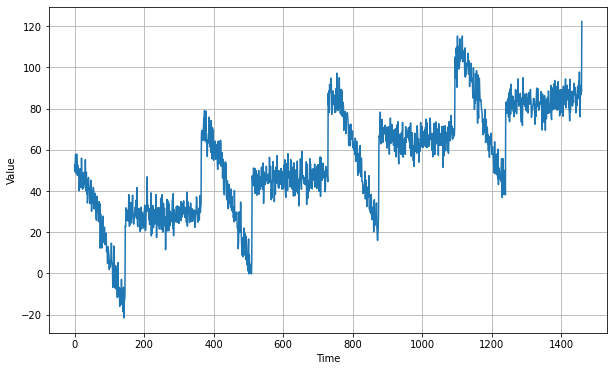

In [4]:
time = np.arange(4 * 365 + 1)

slope = 0.05
baseline = 10
amplitude = 40
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)

noise_level = 5
noise = white_noise(time, noise_level, seed=42)

series += noise

plt.figure(figsize=(10, 6))
plot_series(time, series)
plt.show()

In [0]:
split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

In [3]:
for X_batch, Y_batch in seq2seq_window_dataset(tf.range(10), 3,
                                               batch_size=1):
    print("X:", X_batch.numpy())
    print("Y:", Y_batch.numpy())

X: [[[6]
  [7]
  [8]]]
Y: [[[7]
  [8]
  [9]]]
X: [[[3]
  [4]
  [5]]]
Y: [[[4]
  [5]
  [6]]]
X: [[[0]
  [1]
  [2]]]
Y: [[[1]
  [2]
  [3]]]
X: [[[1]
  [2]
  [3]]]
Y: [[[2]
  [3]
  [4]]]
X: [[[5]
  [6]
  [7]]]
Y: [[[6]
  [7]
  [8]]]
X: [[[4]
  [5]
  [6]]]
Y: [[[5]
  [6]
  [7]]]
X: [[[2]
  [3]
  [4]]]
Y: [[[3]
  [4]
  [5]]]


Find Optimal Learning Rate

In [7]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = seq2seq_window_dataset(x_train, window_size,
                                   batch_size=128)

model = keras.models.Sequential([
  keras.layers.SimpleRNN(100, return_sequences=True,
                         input_shape=[None, 1]),
  keras.layers.SimpleRNN(100, return_sequences=True),
  keras.layers.Dense(1),
  keras.layers.Lambda(lambda x: x * 200)
])
lr_schedule = keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-7 * 10**(epoch / 30))
optimizer = keras.optimizers.SGD(lr=1e-7, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
8/8 [==============================] - 0s 56ms/step - loss: 52.3618 - mae: 52.8614 - lr: 1.0000e-07
Epoch 2/100
8/8 [==============================] - 0s 55ms/step - loss: 25.4714 - mae: 25.9671 - lr: 1.0798e-07
Epoch 3/100
8/8 [==============================] - 0s 49ms/step - loss: 23.5029 - mae: 23.9972 - lr: 1.1659e-07
Epoch 4/100
8/8 [==============================] - 0s 58ms/step - loss: 21.1367 - mae: 21.6294 - lr: 1.2589e-07
Epoch 5/100
8/8 [==============================] - 0s 51ms/step - loss: 19.4762 - mae: 19.9674 - lr: 1.3594e-07
Epoch 6/100
8/8 [==============================] - 0s 50ms/step - loss: 18.6742 - mae: 19.1647 - lr: 1.4678e-07
Epoch 7/100
8/8 [==============================] - 0s 51ms/step - loss: 18.1698 - mae: 18.6587 - lr: 1.5849e-07
Epoch 8/100
8/8 [==============================] - 0s 53ms/step - loss: 17.7679 - mae: 18.2568 - lr: 1.7113e-07
Epoch 9/100
8/8 [==============================] - 0s 54ms/step - loss: 17.4389 - mae: 17.9280 - lr: 1.8

(1e-07, 0.0001, 0.0, 30.0)

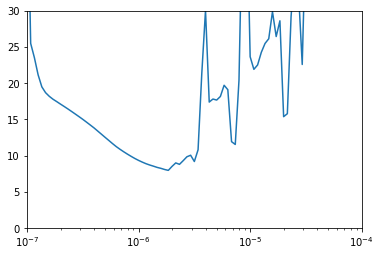

In [8]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-7, 1e-4, 0, 30])

Training the Model

In [9]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = seq2seq_window_dataset(x_train, window_size,
                                   batch_size=128)
valid_set = seq2seq_window_dataset(x_valid, window_size,
                                   batch_size=128)

model = keras.models.Sequential([
  keras.layers.SimpleRNN(100, return_sequences=True,
                         input_shape=[None, 1]),
  keras.layers.SimpleRNN(100, return_sequences=True),
  keras.layers.Dense(1),
  keras.layers.Lambda(lambda x: x * 200.0)
])
optimizer = keras.optimizers.SGD(lr=1.5e-6, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
early_stopping = keras.callbacks.EarlyStopping(patience=10)
model.fit(train_set, epochs=500,
          validation_data=valid_set,
          callbacks=[early_stopping])

Epoch 1/500
8/8 [==============================] - 1s 120ms/step - loss: 53.2440 - mae: 53.7425 - val_loss: 47.3796 - val_mae: 47.8784
Epoch 2/500
8/8 [==============================] - 1s 76ms/step - loss: 34.6001 - mae: 35.0970 - val_loss: 16.7438 - val_mae: 17.2389
Epoch 3/500
8/8 [==============================] - 1s 81ms/step - loss: 24.6003 - mae: 25.0952 - val_loss: 14.0670 - val_mae: 14.5595
Epoch 4/500
8/8 [==============================] - 1s 84ms/step - loss: 18.7984 - mae: 19.2913 - val_loss: 18.4996 - val_mae: 18.9961
Epoch 5/500
8/8 [==============================] - 1s 85ms/step - loss: 15.7819 - mae: 16.2710 - val_loss: 11.5673 - val_mae: 12.0600
Epoch 6/500
8/8 [==============================] - 1s 84ms/step - loss: 13.5109 - mae: 13.9970 - val_loss: 10.0605 - val_mae: 10.5461
Epoch 7/500
8/8 [==============================] - 1s 69ms/step - loss: 12.2219 - mae: 12.7053 - val_loss: 9.2432 - val_mae: 9.7290
Epoch 8/500
8/8 [==============================] - 1s 66ms/step

Testing and Evalauating the Model

In [0]:
# Model Prediction  
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast
    
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

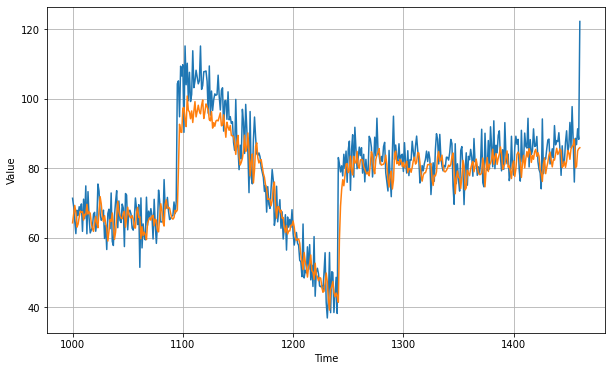

In [12]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

Mean Absolute Error

In [13]:
keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

5.448525